In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [41]:
from sqlalchemy import func
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///SurfsUp/Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# explore measurment
first_measurement = session.query(measurement).first()
first_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e7edc57170>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397'}

In [11]:
# explore measurment
first_station = session.query(station).first()
first_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e7edc56ed0>,
 'latitude': 21.2716,
 'elevation': 3.0,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [71]:
# Find the most recent date in the data set.
 
date_most_recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
date_most_recent

('2017-08-23',)

In [72]:
date_most_recent = date_most_recent.date 
date_most_recent = datetime.strptime(date_most_recent, '%Y-%m-%d')
date_most_recent

datetime.datetime(2017, 8, 23, 0, 0)

In [76]:
date_1y_ago = date_most_recent - relativedelta(years=1)
date_1y_ago = date_1y_ago.strftime('%Y-%m-%d')
date_1y_ago 

'2016-08-23'

In [ ]:
# precipitation_1y = session.query(measurement.date,\
#                                  func.avg(measurement.prcp).label('avg_precipitation' ))\
#     .filter(measurement.date >= date_1y_ago)\
#     .group_by(measurement.date)\
#     .order_by(measurement.date).all()
# precipitation_1y

[('2016-08-23', 0.45166666666666666),
 ('2016-08-24', 1.555),
 ('2016-08-25', 0.07714285714285715),
 ('2016-08-26', 0.016666666666666666),
 ('2016-08-27', 0.064),
 ('2016-08-28', 0.5166666666666666),
 ('2016-08-29', 0.24333333333333332),
 ('2016-08-30', 0.011666666666666667),
 ('2016-08-31', 0.636),
 ('2016-09-01', 0.006),
 ('2016-09-02', 0.05),
 ('2016-09-03', 0.254),
 ('2016-09-04', 0.27599999999999997),
 ('2016-09-05', 0.08499999999999999),
 ('2016-09-06', 0.246),
 ('2016-09-07', 0.3333333333333333),
 ('2016-09-08', 0.07666666666666667),
 ('2016-09-09', 0.17833333333333334),
 ('2016-09-10', 0.27999999999999997),
 ('2016-09-11', 0.25),
 ('2016-09-12', 0.308),
 ('2016-09-13', 0.45166666666666666),
 ('2016-09-14', 2.3800000000000003),
 ('2016-09-15', 0.8266666666666667),
 ('2016-09-16', 0.11714285714285713),
 ('2016-09-17', 0.136),
 ('2016-09-18', 0.10600000000000001),
 ('2016-09-19', 0.064),
 ('2016-09-20', 0.14714285714285716),
 ('2016-09-21', 0.19499999999999998),
 ('2016-09-22', 0.

In [109]:
precipitation_1y = session.query(measurement.date, measurement.prcp)\
    .filter(measurement.date >= date_1y_ago)\
    .order_by(measurement.date).all()
precipitation_1y

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [115]:
precipitation_1y_df = pd.DataFrame(precipitation_1y)
precipitation_1y_df = precipitation_1y_df.rename(columns={'prcp':'precipitation'})
precipitation_1y_df = precipitation_1y_df.dropna(how='any')
precipitation_1y_df

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
4,2016-08-23,0.02
5,2016-08-23,1.79
...,...,...
2225,2017-08-22,0.50
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08


### this plot has no sens, 
because for each day there are different stations collecting data, we should calculate the mean f each day before plotting
but when i do that, the chart is different from the ne expected, so i follow the instructions

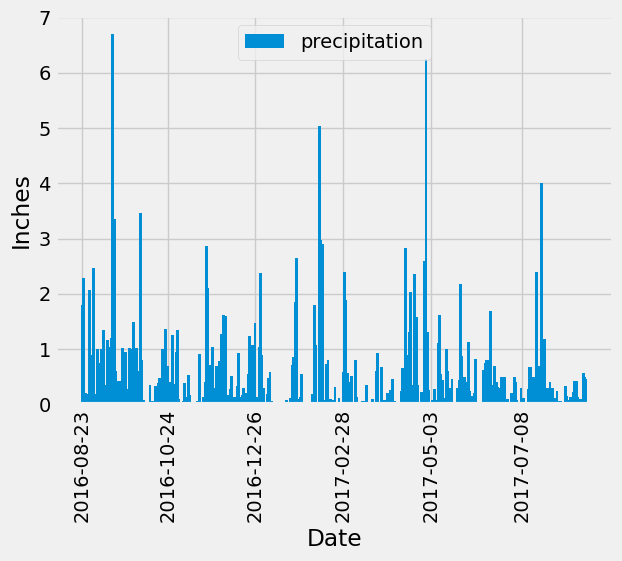

In [118]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.bar(precipitation_1y_df['date'],precipitation_1y_df['precipitation'],\
         label='precipitation', width=2)


plt.xlabel('Date')
plt.xticks(rotation = 90)
plt.ylabel('Inches')
plt.legend(loc='upper center')

# Adjust 'n' based on how many labels you want; try 30 for monthly ticks if dates are daily
n = 360
plt.xticks(precipitation_1y_df['date'][::n])

plt.show()


In [134]:
# Use Pandas to calculate the summary statistics for the precipitation data

summary_df = precipitation_1y_df['precipitation'].describe()
summary_df = summary_df.reset_index()

summary_df = summary_df.rename(columns={'index' : 'stats','prcp':'precipitation'})
summary_df = summary_df.set_index('stats')
summary_df


,precipitation
stats,
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [128]:
# Design a query to calculate the total number of stations in the dataset
station_number = session.query(measurement.station).distinct().count()

print(station_number)


9


In [129]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_active = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc())\
    .all()
station_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [ ]:
# extract the most active station

most_active_station = station_active[0][0]
most_active_station

'USC00519281'

In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_stats = session.query(func.min(measurement.tobs),\
    func.max(measurement.tobs),\
    func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station).\
    all()
most_active_station_stats

[(54.0, 85.0, 71.66378066378067)]

In [140]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature_1y = session.query(measurement.tobs)\
    .filter(measurement.date >= date_1y_ago)\
    .filter(measurement.station == most_active_station) \
    .group_by(measurement.date)\
    .order_by(measurement.date).all()
temperature_1y

[(77.0,),
 (77.0,),
 (80.0,),
 (80.0,),
 (75.0,),
 (73.0,),
 (78.0,),
 (77.0,),
 (78.0,),
 (80.0,),
 (80.0,),
 (78.0,),
 (78.0,),
 (78.0,),
 (73.0,),
 (74.0,),
 (80.0,),
 (79.0,),
 (77.0,),
 (80.0,),
 (76.0,),
 (79.0,),
 (75.0,),
 (79.0,),
 (78.0,),
 (79.0,),
 (78.0,),
 (78.0,),
 (76.0,),
 (74.0,),
 (77.0,),
 (78.0,),
 (79.0,),
 (79.0,),
 (77.0,),
 (80.0,),
 (78.0,),
 (78.0,),
 (78.0,),
 (77.0,),
 (79.0,),
 (79.0,),
 (79.0,),
 (79.0,),
 (75.0,),
 (76.0,),
 (73.0,),
 (72.0,),
 (71.0,),
 (77.0,),
 (79.0,),
 (78.0,),
 (79.0,),
 (77.0,),
 (79.0,),
 (77.0,),
 (78.0,),
 (78.0,),
 (78.0,),
 (78.0,),
 (77.0,),
 (74.0,),
 (75.0,),
 (76.0,),
 (73.0,),
 (76.0,),
 (74.0,),
 (77.0,),
 (76.0,),
 (76.0,),
 (74.0,),
 (75.0,),
 (75.0,),
 (75.0,),
 (75.0,),
 (71.0,),
 (63.0,),
 (70.0,),
 (68.0,),
 (67.0,),
 (77.0,),
 (74.0,),
 (77.0,),
 (76.0,),
 (76.0,),
 (75.0,),
 (76.0,),
 (75.0,),
 (73.0,),
 (75.0,),
 (73.0,),
 (75.0,),
 (74.0,),
 (75.0,),
 (74.0,),
 (75.0,),
 (73.0,),
 (75.0,),
 (73.0,),
 (73.0,),


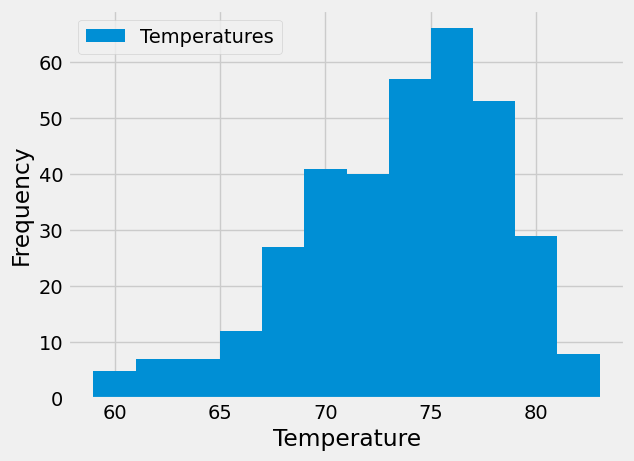

In [ ]:
#convert to DF

temperature_1y_df = pd.DataFrame(temperature_1y)

# plot the DF

plt.hist(temperature_1y_df, bins = 12 , label='Temperatures')

plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc = 'upper left')

# Close Session

In [145]:
# Close Session
session.close()